In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import pickle
warnings.filterwarnings('ignore')

In [92]:
# fa 객체와 회귀계수 데이터 불러오기
with open("data/coef.pickle",'rb') as f:
    factor_coefficients_for_backtest = pickle.load(f)
    fa = pickle.load(f)

In [95]:
# cols와 factor_list 정의, cols는 상관분석으로 걸러진 컬럼들 factor_list는 회귀분석 후 유효한 팩터들
score = pd.read_excel('data/factor_loadings.xlsx',index_col=0)
cols = score.index
factor_list = score.columns

In [96]:
# 스케일러 적합을 위해 15~20년 데이터 불러온 후 스케일러 적합
df_2008_2019 = pd.read_excel('data/ts_rtn_2008_2019.xlsx')
scaler = StandardScaler()
scaler.fit(df_2008_2019[cols])

StandardScaler()

In [97]:
filtered_data = df_2008_2019[cols]
filtered_data

,총자본증가율(IFRS),유형자산증가율(IFRS),투자부동산증가율(IFRS),비유동자산증가율(IFRS),유동자산증가율(IFRS),재고자산증가율(IFRS),자기자본증가율(IFRS),매출액증가율(IFRS),정상영업이익증가율(IFRS),순이익증가율(IFRS),...,매출채권회전기간(IFRS),비유동자산회전률(IFRS),유형자산회전율(IFRS),순운전자본회전률(IFRS),운전자본회전률(IFRS),1회전기간(IFRS),총자본투자효율(IFRS),기계투자효율(IFRS),노동소득분배율(IFRS),이윤분배율(IFRS)
0,11.35,33.72,0.0,29.12,2.65,48.02,11.27,17.74,136.71,166.52,...,95.83,2.35,2.81,1.07,0.00,0.01,13.28,943.98,0.00,73.46
1,41.31,136.95,0.0,118.90,-6.52,57.76,14.64,7.70,19.14,32.67,...,88.03,1.41,1.57,1.00,0.00,0.01,12.25,1204.12,0.00,74.74
2,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,104.67,1.22,1.37,0.88,0.00,0.01,23.73,215.32,66.47,13.91
3,1.83,19.91,0.0,17.06,-15.41,-13.37,5.74,8.96,51.84,60.66,...,93.42,1.22,1.36,1.01,0.00,0.01,24.74,254.08,61.21,21.05
4,-4.46,-2.34,0.0,-1.96,-8.38,-1.77,-1.15,-4.77,-60.96,-92.58,...,88.81,1.09,1.20,1.05,0.00,0.01,23.01,239.59,72.78,1.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3338,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,31.97,3.56,10.85,0.85,0.00,0.02,17.50,50339.81,20.91,55.20
3339,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,27.08,4.06,11.08,3.02,0.05,0.05,15.19,271.68,55.07,0.93
3340,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,64.35,1.63,3.17,1.14,0.11,0.02,14.60,941.37,72.33,2.56
3341,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,22.64,1.17,2.97,1.86,0.10,0.03,6.55,114.21,116.06,-104.87


In [98]:
# 백테스팅 데이터 불러오기
df_original = pd.read_excel('data/ts_rtn_2020_2023.xlsx', dtype = {'주식코드':str})

In [99]:
test_start_year = 2020
test_end_year = 2023 # 테스트 기간 끝 연도 (학습된 모델을 이 기간에 적용)

num_top_firms = 10 # 매년 매수할 상위 기업 수

portfolio_returns_annual = [] # 각 연도별 포트폴리오 수익률 저장
portfolio_years = [] # 수익률이 계산된 연도 저장

In [100]:
df = df_original[cols]

In [101]:
df1 = pd.merge(df_original.iloc[:, :3], df, left_index=True, right_index=True, how = 'outer')
last_df = pd.merge(df1, df_original.iloc[:, -1:], left_index=True, right_index=True, how = 'outer')

In [102]:
return_col_name = '수익률'

In [103]:
last_df

,회사명,주식코드,연도,총자본증가율(IFRS),유형자산증가율(IFRS),투자부동산증가율(IFRS),비유동자산증가율(IFRS),유동자산증가율(IFRS),재고자산증가율(IFRS),자기자본증가율(IFRS),...,비유동자산회전률(IFRS),유형자산회전율(IFRS),순운전자본회전률(IFRS),운전자본회전률(IFRS),1회전기간(IFRS),총자본투자효율(IFRS),기계투자효율(IFRS),노동소득분배율(IFRS),이윤분배율(IFRS),수익률
0,동화약품(주),000020,2020,7.67,22.60,0.00,42.13,-13.00,6.69,9.79,...,1.57,2.60,0.97,0.00,0.01,26.22,1243.33,60.42,26.76,0.364444
1,동화약품(주),000020,2021,2.70,13.16,-0.69,8.63,-3.11,-9.65,3.96,...,1.30,2.26,1.06,0.00,0.01,23.46,570.03,68.87,15.09,-0.172638
2,동화약품(주),000020,2022,3.27,7.78,-43.33,5.38,0.95,28.36,4.51,...,1.41,2.37,1.21,0.00,0.01,23.40,497.24,70.65,18.10,-0.340157
3,동화약품(주),000020,2023,10.23,14.52,0.00,32.95,-15.81,17.36,4.40,...,1.25,2.26,1.32,0.00,0.01,24.44,368.82,64.81,22.59,0.040573
4,(주)경방,000050,2020,-6.47,-36.42,-4.87,6.78,-69.95,-67.10,2.53,...,0.20,4.26,0.68,0.05,0.04,5.85,29079.87,10.08,36.68,0.315000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1238,케이카(주),381970,2023,3.70,5.58,0.00,2.95,4.60,-5.49,-4.44,...,6.94,14.36,5.30,0.00,0.03,35.78,50080.69,42.21,14.31,-0.069881
1239,(주)에프앤에프,383220,2022,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.99,23.84,1.74,0.00,0.01,46.89,0.00,7.43,61.88,0.000000
1240,(주)에프앤에프,383220,2023,32.54,82.49,0.00,34.26,29.85,9.24,38.51,...,1.78,17.69,1.74,0.00,0.01,36.91,0.00,8.78,63.87,-0.532624
1241,에스케이스퀘어(주),402340,2022,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.08,23.00,2.19,0.00,0.00,6.34,80447.21,9.21,91.10,-0.194497


In [104]:
optim = 22

In [105]:
for current_year in range(test_start_year, test_end_year + 1):
    print(f"\n--- 백테스팅 연도: {current_year} ---")

    # 현재 연도(테스트 기간)의 원본 재무 변수 데이터 추출
    current_year_data_raw = last_df[last_df['연도'] == current_year].copy()

    # 재무 변수와 수익률 분리
    x_current_year_raw = current_year_data_raw.iloc[:, 3:-1]
    y_current_year = current_year_data_raw.iloc[:, -1]


    # 2-2. 고정된 Factor 모델 (fa_fixed_model)을 사용하여 Factor Score 계산
    # 학습 기간에서 fit된 FactorAnalyzer 객체를 사용하여 현재 연도 데이터를 transform 합니다.
    # 이렇게 하면 현재 연도의 재무 변수들이 학습 기간에 정의된 Factor 구조에 따라 Factor Score로 변환됩니다.
    current_year_factor_scores = pd.DataFrame(fa.transform(x_current_year_raw),
                                              columns=[f"factor_{i+1}" for i in range(optim)],
                                              index=x_current_year_raw.index)

    # 2-3. Z-score 계산 (현재 연도 Factor Score 바탕)
    # Factor Score 자체의 Z-score는 매년 해당 연도의 기업들 사이에서의 상대적 순위를 반영해야 하므로, 매년 새로 계산합니다.
    # 고정된 유의한 Factor들만 선택합니다.

    if len(factor_list) == 0:
        print(f"  {current_year}년도 데이터에 백테스팅에 사용할 유의한 Factor 컬럼이 없습니다. 다음 연도로 이동.")
        portfolio_returns_annual.append(0)
        portfolio_years.append(current_year)
        continue

    factor_scores_for_zscore = current_year_factor_scores[factor_list]

    scaler_z_period = StandardScaler()
    z_scores_period = scaler_z_period.fit_transform(factor_scores_for_zscore)
    z_scores_df_period = pd.DataFrame(z_scores_period,
                                       columns=[f"{col}_zscore" for col in factor_list],
                                       index=factor_scores_for_zscore.index)

    # 2-4. Z-score 조정 (고정된 회귀 계수 부호에 따라)
    # 학습 기간에 고정된 RLM 회귀 계수의 부호를 사용하여 Z-score의 방향성을 조정합니다.
    adjusted_z_scores_period = z_scores_df_period.copy()
    for factor in factor_list:
        # 고정된 RLM 계수가 음수이면 Z-score 순위를 반전 (높은 Z-score가 좋은 기업이 되도록)
        if factor_coefficients_for_backtest[factor] < 0:
            adjusted_z_scores_period[f"{factor}_zscore"] *= -1

    # 2-5. 기업별 최종 랭크 점수 계산 (조정된 Z-score 합산)
    # 조정된 Z-score들을 합산하여 각 기업의 최종 랭크 점수를 계산합니다.
    firm_rank_score_period = adjusted_z_scores_period.sum(axis=1)
    firm_rank_score_period = firm_rank_score_period.sort_values(ascending=False)

    # 2-6. 포트폴리오 구성: 상위 N개 기업 선정
    # 랭크 점수가 가장 높은 상위 'num_top_firms' 개 기업을 선정합니다.
    top_firms_indices = firm_rank_score_period.head(num_top_firms).index

    # 선정된 기업들의 '주식코드'와 '수익률'을 가져옵니다.
    portfolio_firms_info = current_year_data_raw.loc[top_firms_indices]
    top_firms_codes = portfolio_firms_info['주식코드'].tolist()

    if not top_firms_codes:
        print(f"  {current_year}년도에 포트폴리오에 편입할 기업이 없습니다. 다음 연도로 이동.")
        portfolio_returns_annual.append(0)
        portfolio_years.append(current_year)
        continue

    # 2-7. 포트폴리오 수익률 계산 (선정된 기업들의 현재 연도 '수익률' 평균)
    # 선정된 기업들의 해당 연도 수익률을 평균하여 포트폴리오의 연간 수익률로 간주합니다 (동일 가중 포트폴리오).
    portfolio_avg_return = portfolio_firms_info[return_col_name].mean()
    portfolio_returns_annual.append(portfolio_avg_return)
    portfolio_years.append(current_year)
    print(f"  {current_year}년도 포트폴리오 평균 수익률: {portfolio_avg_return:.2%}")


--- 백테스팅 연도: 2020 ---
  2020년도 포트폴리오 평균 수익률: 69.15%

--- 백테스팅 연도: 2021 ---
  2021년도 포트폴리오 평균 수익률: -13.24%

--- 백테스팅 연도: 2022 ---
  2022년도 포트폴리오 평균 수익률: -18.83%

--- 백테스팅 연도: 2023 ---
  2023년도 포트폴리오 평균 수익률: -8.21%



--- 최종 백테스팅 연간 수익률 ---
2020    0.691464
2021   -0.132377
2022   -0.188331
2023   -0.082138
dtype: float64

--- 누적 수익률 ---
2020    1.691464
2021    1.467554
2022    1.191168
2023    1.093328
dtype: float64


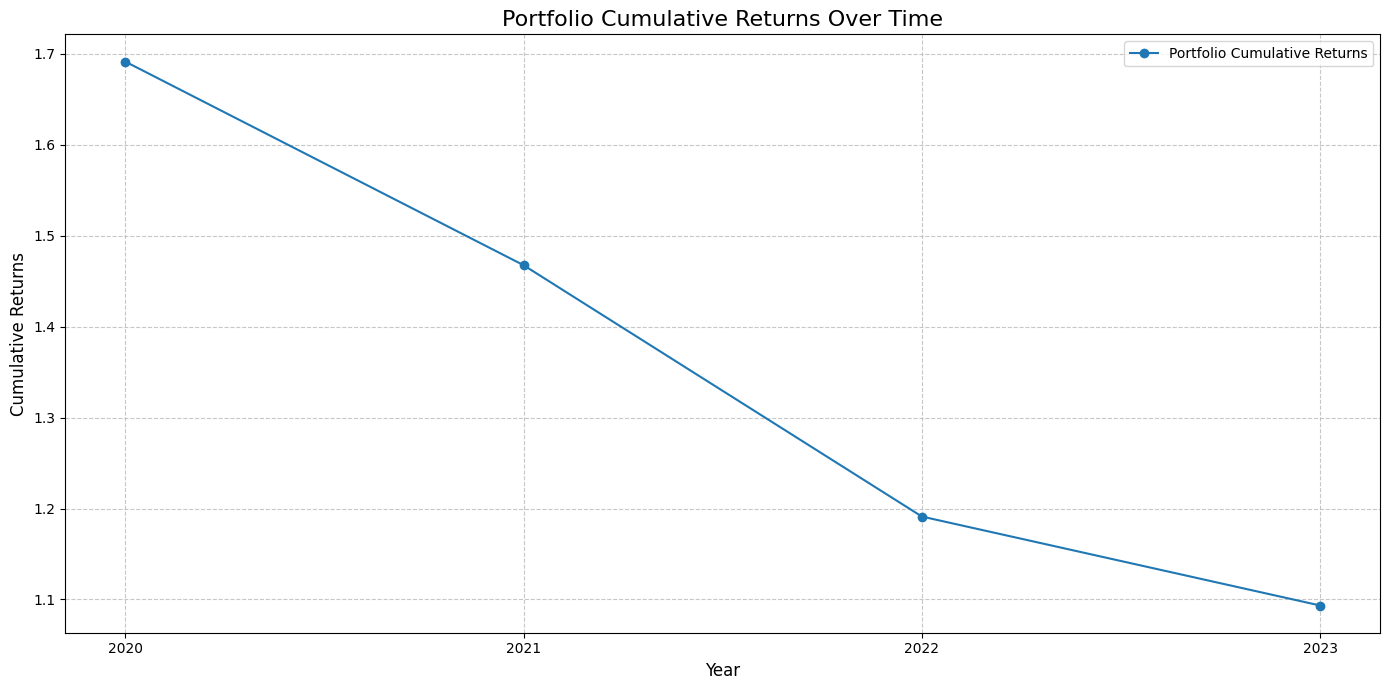


--- 백테스팅 성과 요약 ---
총 백테스팅 기간: 2020년 - 2023년 (4년)
연평균 수익률 (CAGR): 2.26%
연간 변동성 (Standard Deviation): 41.51%
샤프 비율 (무위험 이자율 2.00%): 0.01


In [106]:
if not portfolio_returns_annual:
    print("\n백테스팅을 수행할 충분한 데이터가 없거나 모든 연도에서 포트폴리오 구성에 실패했습니다.")
else:
    portfolio_returns_series = pd.Series(portfolio_returns_annual, index=portfolio_years)

    print("\n--- 최종 백테스팅 연간 수익률 ---")
    print(portfolio_returns_series)

    # 누적 수익률 계산
    cumulative_returns = (1 + portfolio_returns_series).cumprod()
    print("\n--- 누적 수익률 ---")
    print(cumulative_returns)

    # 시각화: 포트폴리오 누적 수익률 그래프
    plt.figure(figsize=(14, 7))
    plt.plot(cumulative_returns.index, cumulative_returns.values, marker='o', linestyle='-', label='Portfolio Cumulative Returns')
    plt.title('Portfolio Cumulative Returns Over Time', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Cumulative Returns', fontsize=12)
    plt.xticks(cumulative_returns.index)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

    # 추가적인 성과 지표 계산
    total_years = len(portfolio_returns_series)
    if total_years > 0:
        # 연평균 수익률 (CAGR: Compound Annual Growth Rate)
        annualized_return = (cumulative_returns.iloc[-1])**(1/total_years) - 1
        # 연간 변동성 (표준편차)
        annualized_volatility = portfolio_returns_series.std()

        # 무위험 이자율 가정 (예: 2%) - 실제 분석에서는 시장 상황에 맞는 무위험 이자율을 사용해야 합니다.
        risk_free_rate = 0.02
        sharpe_ratio = np.nan
        if annualized_volatility > 0:
            sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

        print(f"\n--- 백테스팅 성과 요약 ---")
        print(f"총 백테스팅 기간: {portfolio_returns_series.index.min()}년 - {portfolio_returns_series.index.max()}년 ({total_years}년)")
        print(f"연평균 수익률 (CAGR): {annualized_return:.2%}")
        print(f"연간 변동성 (Standard Deviation): {annualized_volatility:.2%}")
        print(f"샤프 비율 (무위험 이자율 {risk_free_rate:.2%}): {sharpe_ratio:.2f}")
    else:
        print("\n백테스팅 결과가 없어 성과 지표를 계산할 수 없습니다.")